In [1]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [2]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [4]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [6]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

#Read Dataset

In [7]:
#@title Read dataset
df_o = pd.read_csv(path+'application_train.csv')    #HomeCredit training dataset

In [8]:
#@title Create develoment train and test
df_train, df_test = tr.create_train_test(df_o, seed=43)

In [9]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 880
    
print(seed_number)

880


#Params

In [10]:
params_dict = ri.params_dict

In [11]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

#<font color='orange'>Helper Functions</font>


#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [12]:
kf = KFold(n_splits=5)   #80-20 split for train-test
hist_dict = {}

for fold_number, (train_index, test_index) in enumerate(kf.split(df_o)):
    #diferent seed for each iteration
    seed_number = seed_number+fold_number

    df_train = df_o.iloc[train_index]
    df_test = df_o.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    df_train, policy_model = ri.fit_policy(df_train)

    X_train, X_test, X_val = df_train, df_test, df_val
    y_train, y_test, y_val = df_train["TARGET"], df_test["TARGET"], df_val["TARGET"]

    X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model)
    X_test_acp, X_test_rej, y_test_acp, y_test_rej = ri.accept_reject_split(X_test, y_test, policy_clf=policy_model)
    X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model)
    
    models_dict = {}

    benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                  LGBMClassifier(**params_dict['LightGBM_2']))
    benchmark.fit(X_train_acp, y_train_acp)

    
    models_dict['BM'] = benchmark

    models_dict.update(
        ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    models_dict.update(
        ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej, iterations=50,seed=seed_number))

    hist_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test, y_test, X_unl=X_test_rej)


0.24
0.24
0.21


In [26]:
hist_dict[0]

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.732752,0.704700,0.727045,0.731401,0.724669,0.734726,0.735165,0.720406,0.693677
KS,0.343447,0.300631,0.334215,0.341494,0.330416,0.352830,0.350578,0.327287,0.285583
------,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Balanced Accuracy,0.671724,0.650316,0.667107,0.670747,0.665208,0.676415,0.675289,0.663643,0.642792
Accuracy,0.664781,0.657090,0.674861,0.654293,0.689771,0.671707,0.696389,0.695072,0.688064
Precision,0.149658,0.140717,0.150420,0.147031,0.153477,0.152877,0.158984,0.154315,0.144659
Recall,0.679992,0.642248,0.657873,0.690341,0.635958,0.682021,0.650162,0.626218,0.588880
F1,0.245324,0.230853,0.244855,0.242429,0.247278,0.249768,0.255492,0.247613,0.232262


In [29]:
sum([hist_dict[i] for i in range(5)])/5

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.732616,0.709157,0.725734,0.728535,0.724730,0.734780,0.734243,0.723728,0.688689
KS,0.347613,0.310383,0.333768,0.339425,0.333585,0.351157,0.349737,0.332295,0.278561
------,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Balanced Accuracy,0.673806,0.655191,0.666884,0.669712,0.666793,0.675578,0.674869,0.666148,0.639280
Accuracy,0.667508,0.662263,0.670978,0.673888,0.681315,0.681273,0.669927,0.682346,0.645466
Precision,0.152404,0.144533,0.150753,0.152555,0.153054,0.156454,0.153610,0.153407,0.136963
Recall,0.681250,0.646743,0.662014,0.664681,0.649506,0.668750,0.680843,0.646840,0.631975
F1,0.248829,0.236209,0.245406,0.247912,0.247685,0.253348,0.250368,0.247713,0.224624


In [15]:
ri.get_metrics_RI(models_dict, X_test, y_test).T.mean()

Overall AUC          0.743400
KS                   0.363513
------               0.000000
Balanced Accuracy    0.681756
Accuracy             0.669614
Precision            0.153248
Recall               0.696192
F1                   0.251043
dtype: float64

In [44]:
# add kfold
# add topsis/ahp multicriterio
# add criterio de parada

#<font color='red'>PIPELINE NORMAL</font>


#<font color='green'>REJECT INFERENCE</font>

In [53]:
import warnings
warnings.filterwarnings("ignore")

#<font color='green'>Test others strategies:</font>

In [62]:
filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
ri_clfs = joblib.load(filepath)

In [63]:
metrics = ri.get_metrics_RI(ri_clfs, X_test, y_test, X_val_acp, y_val_acp, X_unl)

In [64]:
metrics

,BM,TN_1,TN_2,TN_3,TN_4,TN_5,TN_6,TN_7,TN_8,TN_9,...,TN_70,TN_71,TN_72,TN_73,TN_74,TN_75,TN_76,TN_77,TN_78,TN_79
Overall AUC,0.734613,0.735629,0.73439,0.733303,0.73163,0.730289,0.72917,0.727571,0.727396,0.726961,...,0.708256,0.707685,0.707059,0.708001,0.708937,0.708196,0.708473,0.708284,0.708175,0.707964
KS,0.355752,0.354589,0.353614,0.352995,0.354404,0.351019,0.347955,0.345701,0.345273,0.345715,...,0.307191,0.309942,0.30812,0.311763,0.313094,0.310574,0.310251,0.312872,0.313346,0.310935
------,,,,,,,,,,,...,,,,,,,,,,
Balanced Accuracy,0.670243,0.668327,0.663316,0.675726,0.668099,0.666202,0.662632,0.658675,0.657853,0.656688,...,0.652612,0.650383,0.652616,0.650338,0.654891,0.653465,0.65295,0.650187,0.654452,0.651169
Accuracy,0.605544,0.60717,0.580769,0.663733,0.594082,0.593167,0.587883,0.576948,0.570282,0.561481,...,0.624406,0.621804,0.648246,0.610341,0.682493,0.633491,0.691374,0.600402,0.65914,0.600707
Precision,0.137088,0.136784,0.13151,0.149836,0.134726,0.134052,0.132287,0.129716,0.128648,0.127269,...,0.134768,0.133653,0.13892,0.131889,0.146942,0.136553,0.148393,0.130416,0.141662,0.130751
Recall,0.747191,0.741062,0.761491,0.68999,0.756129,0.753064,0.751532,0.755873,0.762002,0.769918,...,0.686159,0.684372,0.657814,0.697906,0.622063,0.677222,0.607252,0.709397,0.648876,0.711185
F1,0.231671,0.230941,0.224286,0.246207,0.228702,0.22759,0.224974,0.221433,0.220132,0.218431,...,0.225287,0.223632,0.229396,0.221852,0.237728,0.227279,0.238504,0.220328,0.232554,0.220891
-----,,,,,,,,,,,...,,,,,,,,,,
Approval Rate,0.862709,0.864132,0.864497,0.865757,0.860941,0.846531,0.848096,0.850514,0.849579,0.845189,...,0.849762,0.848238,0.854193,0.862424,0.870026,0.870493,0.878907,0.875818,0.880066,0.881529


#<font color='green'>Test Trusted Non-outliers Inference:</font>

    * Loop through rejects selecting most confident predictions on outliers as Accepts

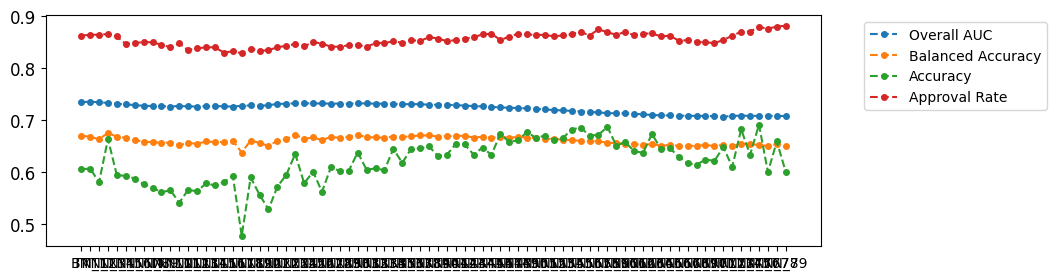

In [65]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

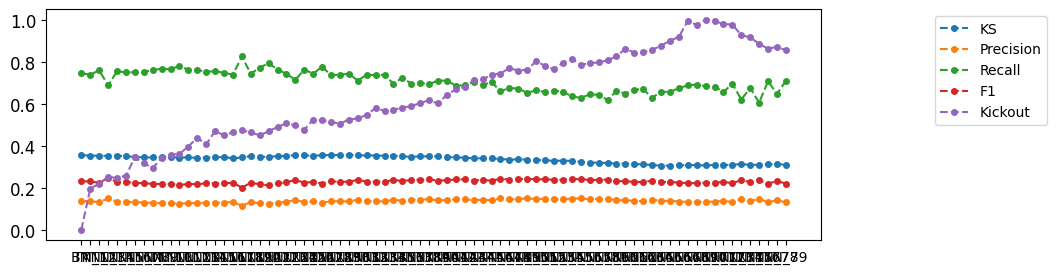

In [66]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

In [ ]:
# C1 = clf_original
# kickout_results = []

# for c2 in results_dict[clf_name]['clf_iterations']:
#     k, kg, kb = ri.calculate_kickout_metric(C1,c2, X_test, y_test, X_val_rej, 0.05)
#     kickout_results.append(k)
#     print(k)

In [ ]:
# plt.plot(kickout_results, marker='o', markersize=3, linestyle='-', label = 'kickout')
# plt.plot(y_mean_list, marker='o', markersize=3, linestyle='-', label = 'y_mean_list')
# plt.plot(auc_loss, marker='o', markersize=3, linestyle='-', label = 'auc_loss')
# plt.legend()

In [ ]:
# AR_original = ri.calculate_approval_rate(clf_original, X_val_acp, y_val_acp, X_test)
# AR_original

In [ ]:
# thrs = []
# for clf_ri in results_dict[clf_name]['clf_iterations']:
#     thr = ri.risk_score_threshold(clf_ri, X_val_acp, y_val_acp)
#     thrs += [thr]

In [ ]:
# AR = []
# for c2, thr in zip(results_dict[clf_name]['clf_iterations'], thrs):
#     k = ri.calculate_approval_rate(c2, X_val_acp, y_val_acp, X_test)
#     AR.append(k)
#     # print(k)

In [ ]:
# plt.plot(AR)
# plt.plot(np.arange(len(AR)), [AR_original]*len(AR))

In [ ]:
print(time.localtime().__reduce__())

(<class 'time.struct_time'>, ((2023, 11, 29, 13, 19, 24, 2, 333, 0), {'tm_zone': '-03', 'tm_gmtoff': -10800}))


In [ ]:
# metrics_poster = metrics_techniques.loc[["Overall AUC", "Kickout"],:]
# metrics_poster = metrics_poster.astype(float).round(3)
# metrics_poster

In [ ]:

# filepath = Path(os.path.join(save_path,str(seed_number)+'_metrics_poster.csv'))
# filepath.parent.mkdir(parents=True, exist_ok=True)
# metrics_poster.to_csv(filepath)